In [1]:
"""

Inspect Spectra for Clump of "AGN" in MEx diagram z > 0.3

Author: Alan Nguyem

20-05-2020

"""

'\n\nInspect Spectra for Clump of "AGN" in MEx diagram z > 0.3\n\nAuthor: Alan Nguyem\n\n20-05-2020\n\n'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
from scipy.optimize import curve_fit, leastsq
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
from BOSS_func_v6 import *
import os
from scipy.integrate import simps
from numpy import trapz

In [4]:
def array_summary(array):
    mean = np.mean(array)
    std = np.std(array)
    minimum = np.min(array)
    maximum = np.max(array)
    
    print("             Count:   {}".format(len(array)))
    print("              Mean:   {}".format(mean))
    print("Standard Deviation:   {}".format(std))
    print("           Minimum:   {}".format(minimum))
    print("           Maximum:   {}".format(maximum))

In [3]:
hdul = fits.open('mid_z_clump_sources2.fits')

mid_z_clump_data = hdul[1].data

hdul.close()

In [6]:
csq = mid_z_clump_data['CHISQ']

In [7]:
array_summary(csq)

             Count:   1714
              Mean:   1.0021953582763672
Standard Deviation:   0.1819988191127777
           Minimum:   0.7046730518341064
           Maximum:   3.5347883701324463


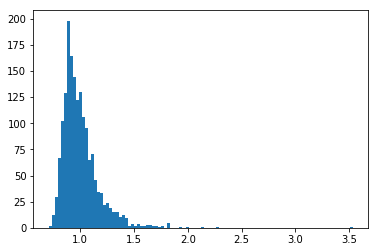

In [9]:
plt.hist(csq, bins = 100)
plt.show()

In [10]:
select_good_chisq = (csq > 0.82) & (csq < 1.18)

In [11]:
mid_z_clump_lowcsq_data = mid_z_clump_data[select_good_chisq]

In [13]:
len(mid_z_clump_data)

1714

In [12]:
len(mid_z_clump_lowcsq_data)

1395

In [5]:
mid_z_clump_OIIIFLUX = mid_z_clump_data['FLUX'][:, 17]
mid_z_clump_HBFLUX = mid_z_clump_data['FLUX'][:, 15]

In [6]:
hdul = fits.open("SummerAGNProj2019/portsmouth_emlinekin_full-DR12.fits")

emlinkin_data = hdul[1].data

hdul.close()

In [25]:
emlinkin_data_OIIIFLUX = emlinkin_data['FLUX'][:, 17]
emlinkin_data_HBFLUX = emlinkin_data['FLUX'][:, 15]

emlinkin_data_OIIIFLUX_err = emlinkin_data['FLUX_ERR'][:, 17]
emlinkin_data_HBFLUX_err = emlinkin_data['FLUX_ERR'][:, 15]

OIII_SN = emlinkin_data_OIIIFLUX / emlinkin_data_OIIIFLUX_err
HB_SN = emlinkin_data_HBFLUX / emlinkin_data_HBFLUX_err

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


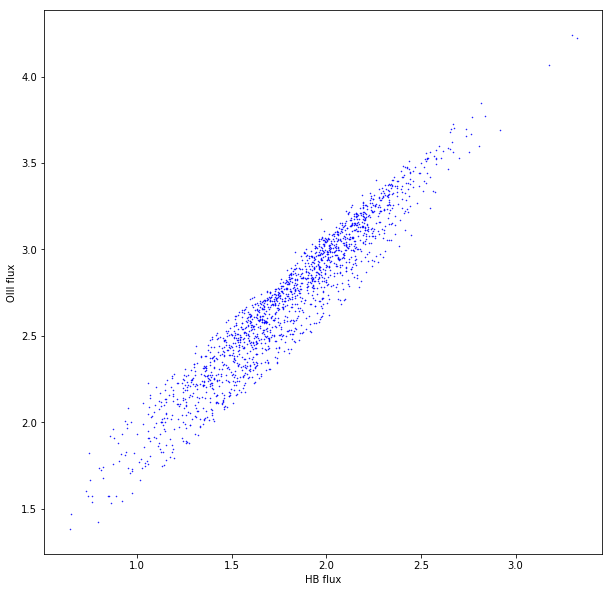

In [18]:
plt.figure(figsize=(10,10))

# plt.plot(emlinkin_data_OIIIFLUX, emlinkin_data_HBFLUX, color = 'r', marker = '.', linestyle = '', ms = 0.2)
plt.plot(np.log10(mid_z_clump_HBFLUX), np.log10(mid_z_clump_OIIIFLUX), color = 'b', marker = '.', linestyle = '', ms = 1)

plt.xlabel('HB flux')
plt.ylabel('OIII flux')

plt.show()

In [37]:
select_good  =  (HB_SN>3)&(HB_SN!=np.nan)&(HB_SN<1000)&(OIII_SN>3)&(OIII_SN<1000)&(OIII_SN!=np.nan)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [38]:
emlinkin_good_data = emlinkin_data[select_good]

In [39]:
emlinkin_good_data_OIIIFLUX = emlinkin_good_data['FLUX'][:, 17]
emlinkin_good_data_HBFLUX   = emlinkin_good_data['FLUX'][:, 15]

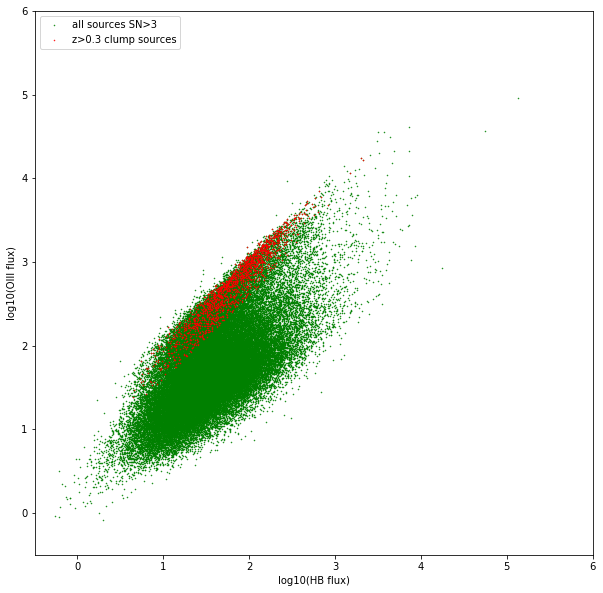

In [52]:
plt.figure(figsize=(10,10))

plt.plot(np.log10(emlinkin_good_data_HBFLUX), np.log10(emlinkin_good_data_OIIIFLUX), color = 'g', marker = '.', linestyle = '', ms = 1, label = 'all sources SN>3')
plt.plot(np.log10(mid_z_clump_HBFLUX), np.log10(mid_z_clump_OIIIFLUX), color = 'r', marker = '.', linestyle = '', ms = 1, label = 'z>0.3 clump sources')

plt.xlabel('log10(HB flux)')
plt.ylabel('log10(OIII flux)')

plt.ylim((-0.5, 6))
plt.xlim((-0.5, 6))

plt.legend()

plt.show()

In [14]:
#
#create a dictionary containing important parameters and the spectrum plots for the full wavelength range
#

specs = {} #create a dictionary to store the spectra
count = 0 #for a loading bar lmao

for row in mid_z_clump_data: #for each line (each spectrum) in the file take the following
    key = 'spec-' + str(row['PLATE']) + '-' + str(row['MJD']) + '-' + str('{:04}'.format(row['FIBERID']))
    filename = key + '.fits'
    filedir = os.path.join('random_clump_specs', filename)
    
    try:
        hdul = fits.open(filedir) #using above directory open fits for the specific spectra
        
        data = hdul[1].data #again take only data not the header
        
        hdul.close()
        
        wave = 10 ** data['loglam'] #convert wavelength back to linear scale
        flux = data['flux'] #take fluxden
        inverse_variance = data['ivar'] #take inverse variance
        error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
        model = data['model']
        
        z = row['Z']
        k = 1 + z

        ###############################
        ###############################

        tempdat = [] #temporary list to hold each dataset before adding it to the dictionary

        #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
        tempdat.append(wave) #0 
        tempdat.append(flux) #1
        tempdat.append(k)    #2
        tempdat.append(error)#3
        tempdat.append(model)#4

        specs.update({key:tempdat})

        ###############################
        ###############################

        count += 1
        print("\r" + "Complete: {}/{}".format(count,len(seyferts)), end = "") #progress bar to keep track of progress

    except:
        print(':-)')

:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)
:-)


In [5]:
print(len(specs))

14


Flux_Ratio =  1.1075161496981802


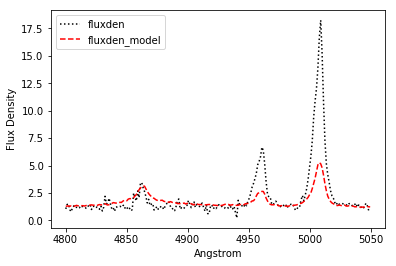

28.359653386595024
Flux_Ratio =  1.1075161496981802


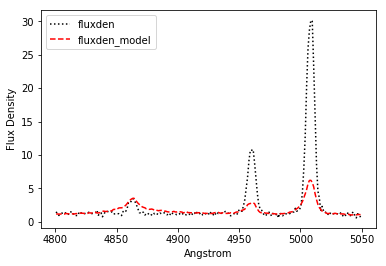

56.950608132102275
Flux_Ratio =  1.1075161496981802


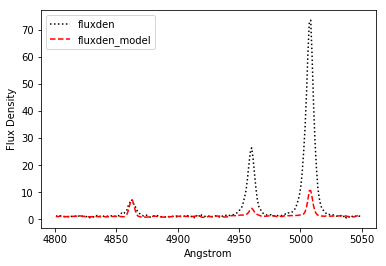

167.0376065340909
Flux_Ratio =  1.1075161496981802


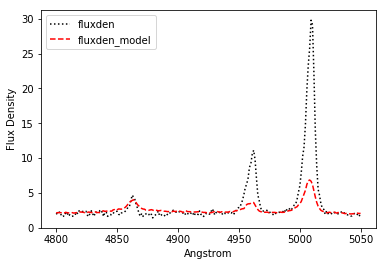

53.80947751696833
Flux_Ratio =  1.1075161496981802


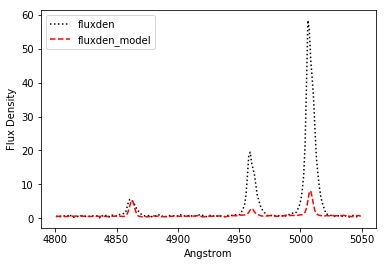

173.8030184659091
Flux_Ratio =  1.1075161496981802


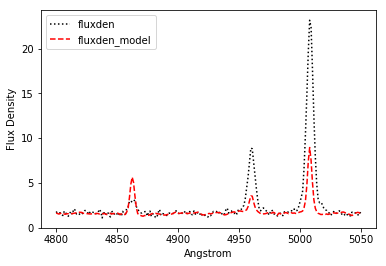

44.72821956306561
Flux_Ratio =  1.1075161496981802


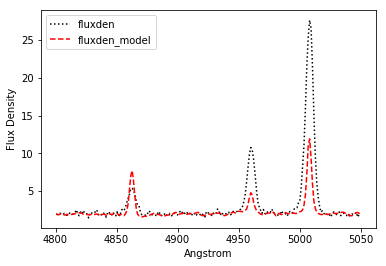

53.08170425622172
Flux_Ratio =  1.1075161496981802


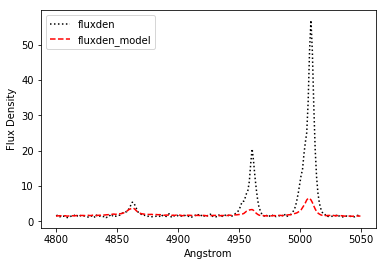

123.2881610576923
Flux_Ratio =  1.1075161496981802


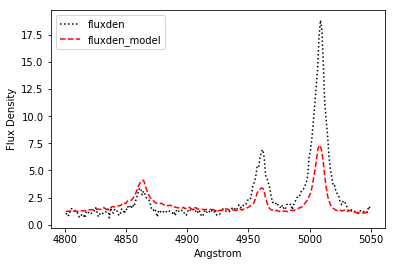

38.54598721590909
Flux_Ratio =  1.1075161496981802


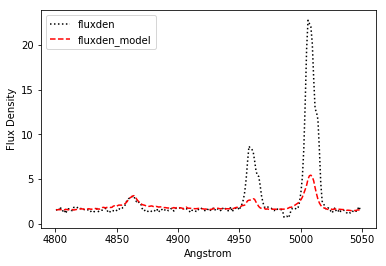

112.74888139204545
Flux_Ratio =  1.1075161496981802


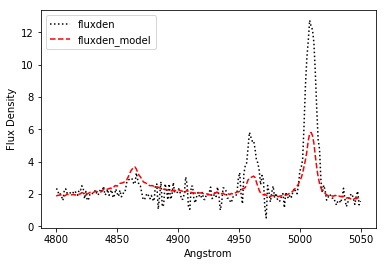

12.841981361354637
Flux_Ratio =  1.1075161496981802


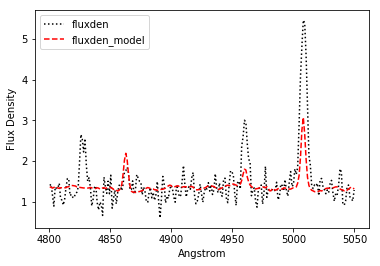

3.6225077771493215
Flux_Ratio =  1.1075161496981802


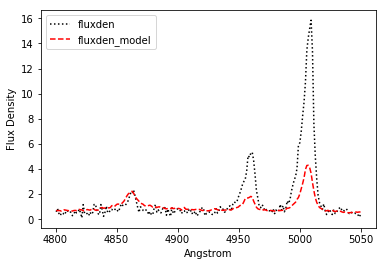

29.391237008625566
Flux_Ratio =  1.1075161496981802


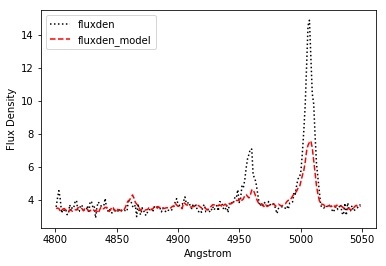

12.107227672230113


<Figure size 432x288 with 0 Axes>

In [16]:
count = 1

for spec in specs:
    wavelength = specs[spec][0]
    fluxden = specs[spec][1]
    k = specs[spec][2]
    error = specs[spec][3]
    model = specs[spec][4]
    
    spectral_resolution = (wavelength[-1] - wavelength[0]) / len(wavelength)
    
    rest_frame_wavelength = wavelength / k
    
    select_OIIIHB = (rest_frame_wavelength > 4800) & (rest_frame_wavelength < 5050)
    
    rest_frame_wavelength_OIIIHB = rest_frame_wavelength[select_OIIIHB]
    fluxden_OIIIHB = fluxden[select_OIIIHB]
    model_OIIIHB = model[select_OIIIHB]
    error_OIIIHB = error[select_OIIIHB]
    
    continuum_level = ( fluxden_OIIIHB[0] + fluxden_OIIIHB[-1] ) / 2
    
    continuum_sub_fluxden_OIIIHB = fluxden_OIIIHB - continuum_level
    continuum_sub_model_OIIIHB = model_OIIIHB - continuum_level
    
    
#     OIII_fluxden = continuum_sub_fluxden_OIIIHB[165:200]
#     HB_fluxden   = continuum_sub_fluxden_OIIIHB[48:65]
    
#     OIII_flux = simps(OIII_fluxden, dx = spectral_resolution)
#     HB_flux = simps(HB_fluxden, dx = spectral_resolution)
    
#     OIII_fluxden = continuum_sub_model_OIIIHB[175:190]
#     HB_fluxden   = continuum_sub_model_OIIIHB[50:60]
    
#     OIII_flux = simps(OIII_fluxden, dx = spectral_resolution)
#     HB_flux = simps(HB_fluxden, dx = spectral_resolution)
    
#     print('OIII_flux = ', OIII_flux)
#     print('HB_flux   = ', HB_flux)
    print('Flux_Ratio = ', np.log10(OIII_flux / HB_flux))
    
    
    plt.plot(rest_frame_wavelength_OIIIHB, fluxden_OIIIHB, 'k:', label = 'fluxden')
    
#     plt.plot(rest_frame_wavelength_OIIIHB[175:190], continuum_sub_model_OIIIHB[175:190], 'g-', label = 'fluxden')
#     plt.plot(rest_frame_wavelength_OIIIHB[50:60], continuum_sub_model_OIIIHB[50:60], 'b-', label = 'fluxden')
#     plt.plot(rest_frame_wavelength_OIIIHB, error_OIIIHB, 'b-', label = 'fluxden_error')
    plt.plot(rest_frame_wavelength_OIIIHB, model_OIIIHB, 'r--', label = 'fluxden_model')

#     print(len(continuum_sub_fluxden_OIIIHB))
    
#     plt.axvline(5007)
#     plt.axvline(4861)
    
    plt.legend()
    
    plt.xlabel('Angstrom')
    plt.ylabel('Flux Density')
    
#     figfilename = 'MEx_clump_spectra' + str(count) + '.jpg'
    
#     plt.savefig(figfilename)
    
    plt.show()
    
    plt.clf()
    
    similarity1 = np.sum(((fluxden_OIIIHB - model_OIIIHB) / error_OIIIHB) ** 2) #take csq between current data in iteration and fits from preset
    similarity2 = similarity1 / len(fluxden_OIIIHB) #divide by length for reduced chi squared
    
    print(similarity2)
    
#     fluxden_area = simps(continuum_sub_fluxden_OIIIHB, dx = spectral_resolution)
#     print('fluxden_area = ', fluxden_area)
    
#     model_area = simps(continuum_sub_model_OIIIHB, dx = spectral_resolution)
#     print('model_area = ', model_area)
    
    
    
    count += 1

In [28]:
select = (48:65)

SyntaxError: invalid syntax (<ipython-input-28-f6867e32dbc4>, line 1)